Copyright (C) 2019 Willy Po-Wei Wu <maya6282@gmail.com> and Elvis Yu-Jing Lin <elvisyjlin@gmail.com>

This work is licensed under the Creative Commons Attribution-NonCommercial
4.0 International License. To view a copy of this license, visit
http://creativecommons.org/licenses/by-nc/4.0/ or send a letter to
Creative Commons, PO Box 1866, Mountain View, CA 94042, USA.

#### Some Abbreviations
1. cm: confusion matrix
2. rp: classification report
3. fi: feature importance
4. if: important features

In [1]:
# Import all used packages

import argparse
import collections
import json
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.utils import class_weight

from tqdm import tqdm

from learn import get_model, get_params
from utils import run_from_ipython, np2df
from viz import show_cm_list, show_rp_list

if run_from_ipython():
    import matplotlib
    %matplotlib inline
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set_context('notebook')  # 'notebook', 'paper', 'talk', 'poster'
    # sns.set_style('dark')  # None, 'darkgrid', 'whitegrid', 'dark', 'white', 'ticks'

In [2]:
# Parse Arguments

def parse(args=None):
    parser = argparse.ArgumentParser(
        prog='Classification',
        description='Train and test a machine learning classification method on the extracted features.'
    )
    parser.add_argument('--n_folds', help='n folds cross validation', type=int, default=10)
    parser.add_argument('--feature_type', '-f',
                        help='feature type ("b" | "e" | "m" or "if4", "if5", "if10", "if13", "if20", "if64")',
                        type=str, default='bem')
    parser.add_argument('--scheme', '-s', help='data scheme', type=str,
                        choices=['address', 'entity'], default='address')
    parser.add_argument('--gpu', help='use GPU', action='store_true')
    parser.add_argument('--output', '-o', help='output path', type=str, default='./data_p')
    parser.add_argument('--result', '-r', help='result path', type=str, default='./result')
    parser.add_argument('--temp', '-t', help='temp path', type=str, default='./temp')
    return parser.parse_args() if args is None else parser.parse_args(args)
args = parse([]) if run_from_ipython() else parse()
print(args)

Namespace(feature_type='bem', gpu=False, n_folds=10, output='./data_p', result='./result', scheme='address', temp='./temp')


In [3]:
# Define the experiment setting

n_folds = args.n_folds                       # 10
feature_type = args.feature_type             # 'b' | 'e' | 'm' or 'if4', 'if5', 'if10', 'if13', 'if20', 'if64'
scheme = args.scheme                         # 'address', 'entity'
gpu = args.gpu
output_path = args.output
result_path = args.result
temp_path = args.temp

# Check the experiment setting

assert not feature_type.startswith('if') and len(feature_type) > 0 or \
       feature_type.startswith('if') and feature_type[2:].isdigit()
assert scheme in ['address', 'entity']

# Number of epochs to train
# The specified epochs are enough to converge for each scheme
if scheme == 'address':
    epochs = 4000
elif scheme == 'entity':
    epochs = 1500

# Show the experiment setting

print('Experiment Setting')
print('===> Feature Types:  ', feature_type)
print('===> Data Scheme:    ', scheme)
print('===> Use GPU:        ', gpu)
print('===> Training epochs:', epochs)

Experiment Setting
===> Feature Types:   bem
===> Data Scheme:     address
===> Use GPU:         False
===> Training epochs: 4000


In [4]:
# 定義一個函數來加載和抽樣數據
def load_sample(file_path, sample_fraction=0.1):
    chunks = []
    for chunk in pd.read_csv(file_path, chunksize=100000):
        chunks.append(chunk.sample(frac=sample_fraction))
    return pd.concat(chunks)

In [5]:
# Load transaction history summarization data

# 設定樣本比例
sample_fraction = 0.04  # 取 0.4% 的數據樣本

# data_file = 'data.{}.csv'.format(scheme)
data_file = 'nanzero_normalization_data.{}.csv'.format(scheme)
# data_file = 'quantum_qubo_data.{}.csv'.format(scheme)
# data_file = 'all_selected_features_quantum_qubo_data.{}.csv'.format(scheme)
file_path = os.path.join(output_path, data_file)
data = load_sample(file_path, sample_fraction)
# data = pd.read_csv(os.path.join(output_path, data_file))
print (data)
if run_from_ipython():
    data.head(4)
else:
    print(data.head(4))

             n_tx  total_days  total_spent_btc  total_received_btc  \
54230   -0.021552   -0.400931        -0.021347           -0.021347   
43326    0.137544    1.097574         0.000524            0.000524   
62749   -0.101101    1.153768        -0.021112           -0.021112   
22841   -0.180649   -0.400931        -0.018970           -0.018970   
65688   -0.021552    3.926002        -0.018031           -0.018031   
...           ...         ...              ...                 ...   
1808699  1.251220    0.591828         0.359496            0.359496   
1854129 -0.180649   -0.400931        -0.021269           -0.021269   
1832922 -0.101101    1.790632        -0.021304           -0.021304   
1851766 -0.180649   -0.400931        -0.021296           -0.021296   
1854131 -0.180649   -0.400931        -0.021260           -0.021260   

         total_spent_usd  total_received_usd  mean_balance_btc  \
54230          -0.014143           -0.014143         -0.132616   
43326          -0.013116   

In [6]:
# Define 4 types of features (basic statistics, extra statistics, moments and patterns)

basic = [
    'f_tx', 'f_received', 'f_coinbase',
    'f_spent_digits_-3', 'f_spent_digits_-2', 'f_spent_digits_-1', 'f_spent_digits_0',
    'f_spent_digits_1', 'f_spent_digits_2', 'f_spent_digits_3', 'f_spent_digits_4',
    'f_spent_digits_5', 'f_spent_digits_6', 'f_received_digits_-3', 'f_received_digits_-2',
    'f_received_digits_-1', 'f_received_digits_0', 'f_received_digits_1', 'f_received_digits_2',
    'f_received_digits_3', 'f_received_digits_4', 'f_received_digits_5', 'f_received_digits_6',
    'r_payback', 'n_inputs_in_spent', 'n_outputs_in_spent'
]
extra = [
    'n_tx', 'total_days', 'n_spent', 'n_received', 'n_coinbase', 'n_payback',
    'total_spent_btc', 'total_received_btc',
    'total_spent_usd', 'total_received_usd',
    'mean_balance_btc', 'std_balance_btc',
    'mean_balance_usd', 'std_balance_usd'
]
moments = [
    'interval_1st_moment', 'interval_2nd_moment', 'interval_3rd_moment', 'interval_4th_moment',
    'dist_total_1st_moment', 'dist_total_2nd_moment', 'dist_total_3rd_moment', 'dist_total_4th_moment',
    'dist_coinbase_1st_moment', 'dist_coinbase_2nd_moment', 'dist_coinbase_3rd_moment', 'dist_coinbase_4th_moment',
    'dist_spend_1st_moment', 'dist_spend_2nd_moment', 'dist_spend_3rd_moment', 'dist_spend_4th_moment',
    'dist_receive_1st_moment', 'dist_receive_2nd_moment', 'dist_receive_3rd_moment', 'dist_receive_4th_moment',
    'dist_payback_1st_moment', 'dist_payback_2nd_moment', 'dist_payback_3rd_moment', 'dist_payback_4th_moment'
]
patterns =[
    'tx_input', 'tx_output',
    'n_multi_in', 'n_multi_out', 'n_multi_in_out'
]

features = []
if not feature_type.startswith('if') and len(feature_type) > 0:
    if 'b' in feature_type:
        features += basic
    if 'e' in feature_type:
        features += extra
    if 'm' in feature_type:
        features += moments
    if 'p' in feature_type:
        features += patterns
        print("Patterns included:", patterns)
elif feature_type.startswith('if') and feature_type[2:].isdigit():
    """
    Important features from LightGBM with BEM
    [ 0 25 24 29 40 37 27 23 56 36  1 28 26 57 32 38 44 45 33 18 39 60 53 35
     34 52 41 17 14 15 16 19 42  5  6 47  7 46  2 54  4 43  8 59 58 55  9 13
     61 48  3 31 10 62 20 21 63 30 49 11 51 50 22 12]
    """
    all_features = basic + extra + moments + patterns
    if_indices = [
        0, 25, 24, 29, 40, 37, 27, 23, 56, 36,
        1, 28, 26, 57, 32, 38, 44, 45, 33, 18,
        39, 60, 53, 35, 34, 52, 41, 17, 14, 15,
        16, 19, 42, 5, 6, 47, 7, 46, 2, 54,
        4, 43, 8, 59, 58, 55, 9, 13, 61, 48,
        3, 31, 10, 62, 20, 21, 63, 30, 49, 11,
        51, 50, 22, 12
    ]
    if_features = [all_features[i] for i in if_indices]
    n_if = int(feature_type[2:])
    features = if_features[:n_if]
else:
    raise Exception('Invalid feature types: {:s}'.format(feature_type))

invalid_features = [feature for feature in features if feature not in data.columns]
assert len(invalid_features) == 0, 'Invalid features: ' + ', '.join(invalid_features)

X = data.get(features).values
y = data['class'].values
print (features)
print (feature_type)
print (X)
print (y)

class2label = json.loads(open(os.path.join(output_path, 'class2label.json'), 'r').read())
label2class = json.loads(open(os.path.join(output_path, 'label2class.json'), 'r').read())
class_names = np.array([label2class[i] for i in range(6)])
print (class_names)
y_names = class_names
# y_names = class_names[y]
# y_names = np.array(class_names)[y.astype(int)]

print(len(X), len(y), len(features))

os.makedirs(result_path, exist_ok=True)

['f_tx', 'f_received', 'f_coinbase', 'f_spent_digits_-3', 'f_spent_digits_-2', 'f_spent_digits_-1', 'f_spent_digits_0', 'f_spent_digits_1', 'f_spent_digits_2', 'f_spent_digits_3', 'f_spent_digits_4', 'f_spent_digits_5', 'f_spent_digits_6', 'f_received_digits_-3', 'f_received_digits_-2', 'f_received_digits_-1', 'f_received_digits_0', 'f_received_digits_1', 'f_received_digits_2', 'f_received_digits_3', 'f_received_digits_4', 'f_received_digits_5', 'f_received_digits_6', 'r_payback', 'n_inputs_in_spent', 'n_outputs_in_spent', 'n_tx', 'total_days', 'n_spent', 'n_received', 'n_coinbase', 'n_payback', 'total_spent_btc', 'total_received_btc', 'total_spent_usd', 'total_received_usd', 'mean_balance_btc', 'std_balance_btc', 'mean_balance_usd', 'std_balance_usd', 'interval_1st_moment', 'interval_2nd_moment', 'interval_3rd_moment', 'interval_4th_moment', 'dist_total_1st_moment', 'dist_total_2nd_moment', 'dist_total_3rd_moment', 'dist_total_4th_moment', 'dist_coinbase_1st_moment', 'dist_coinbase_2n

In [ ]:
# def data_distribution(df):
#     if run_from_ipython():
#         plt.figure()
#         sns.countplot(df.index)
#     cnt = collections.Counter(df.index)
#     print(cnt)
#     return np.array([cnt[i] for i in range(len(cnt))])

# print(class2label)
# y_count = data_distribution(np2df(X, y))

In [7]:
import os
import pickle
import shutil
from tqdm import tqdm

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.models import Sequential, load_model

# 如果不想使用 GPU，可以設置環境變量
if not gpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# GPU 配置 for TensorFlow 2.x
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # 為每個 GPU 設置允許記憶體增長
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

def build_model(input_size, num_classes, summary=False):
    model = Sequential([
        Dense(512, activation='relu', input_shape=(input_size,)),
        BatchNormalization(momentum=0.0, epsilon=1e-5),
        # Dropout(0.2),
        # Dense(512, activation='relu'),
        # BatchNormalization(momentum=0.0, epsilon=1e-5),
        # Dropout(0.2),
        # Dense(512, activation='relu'),
        # BatchNormalization(momentum=0.0, epsilon=1e-5),
        Dropout(0.2),
        Dense(512, activation='relu'),
        BatchNormalization(momentum=0.0, epsilon=1e-5),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    if summary:
        model.summary()
    return model


In [9]:
import time
import numpy as np
import os
import shutil
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from keras.models import load_model
import keras

# 加入時間模組

# 訓練過程
train_cm_list = []
train_rp_list = []
valid_cm_list = []
valid_rp_list = []
fi_list = []

# Add these lists to store AUC scores
train_auc_list = []
valid_auc_list = []

# 宣告 K-Fold
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)

# # 標準化資料
# print('Normalizing data...')
# X = np.nan_to_num((X - np.mean(X, axis=0)) / np.std(X, axis=0))
# X = np.clip(X, np.percentile(X, 1, axis=0), np.percentile(X, 99, axis=0))

# 開始計算整體訓練時間
total_start_time = time.time()  # 全部訓練開始時間

# 開始交叉驗證
for i, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    # 取得分割的訓練集和驗證集
    X_train, X_valid = X[train_idx], X[valid_idx]
    y_train, y_valid = y[train_idx], y[valid_idx]
    y_train_ = keras.utils.to_categorical(y_train, num_classes=len(class2label))
    y_valid_ = keras.utils.to_categorical(y_valid, num_classes=len(class2label))
    
    # 建立模型
    model = build_model(X.shape[1], len(label2class), summary=(i==0))
    model.compile(
        optimizer=keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.999),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # 訓練模型
    acc = -1
    for epoch in range(epochs):
        model.train_on_batch(X_train, y_train_)
        accs = model.test_on_batch(X_valid, y_valid_)
        if accs[1] > acc:
            acc = accs[1]
            print(acc, epoch)
            model.save(os.path.join(temp_path, 'model.h5'))
    model = load_model(os.path.join(temp_path, 'model.h5'))
    
    # 在訓練集上評估
    y_pred = np.argmax(model.predict(X_train), axis=1)
    cm = confusion_matrix(y_train, y_pred)
    cm_sum = cm.sum(axis=1, keepdims=True)
    cm_sum[cm_sum == 0] = 1  # 防止除零
    cm = cm / cm_sum
    train_cm_list.append(cm)
    
    # 在驗證集上評估
    y_pred = np.argmax(model.predict(X_valid), axis=1)
    cm = confusion_matrix(y_valid, y_pred)
    cm = cm / cm.sum(axis=1, keepdims=True)
    valid_cm_list.append(cm)
    rp = classification_report(y_valid, y_pred, target_names=class_names, output_dict=True)
    valid_rp_list.append(rp)
    
    # Calculate AUC for the training set
    y_train_prob = model.predict(X_train)
    train_auc = roc_auc_score(y_train, y_train_prob, multi_class="ovr", average="macro")
    train_auc_list.append(train_auc)

    # Calculate AUC for the validation set
    y_valid_prob = model.predict(X_valid)
    valid_auc = roc_auc_score(y_valid, y_valid_prob, multi_class="ovr", average="macro")
    valid_auc_list.append(valid_auc)

# 全部訓練結束時間
total_end_time = time.time()
total_training_time = total_end_time - total_start_time  # 計算總訓練時間
print(f"Total training time: {total_training_time:.2f} seconds")  # 輸出總訓練時間

# 清除臨時檔案
shutil.rmtree(temp_path)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 512)               33280     
                                                                 
 batch_normalization_2 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 batch_normalization_3 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 512)              

C:\Users\SIEMINGFONG\AppData\Roaming\Python\Python38\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


0.37383052706718445 1
0.4470619857311249 2
0.4548024535179138 4
0.4628121554851532 6
0.46516793966293335 7
0.4722353219985962 8
0.4776199758052826 9
0.4809180796146393 10
0.48138925433158875 11
0.4818603992462158 12
0.4852258265018463 13
0.4866392910480499 14
0.4899373948574066 15
0.49148550629615784 16
0.5275627374649048 19
0.5280339121818542 20
0.5305243134498596 22
0.5322070121765137 23
0.5348993539810181 26
0.5352359414100647 30
0.5373897552490234 33
0.5400820970535278 35
0.5456687211990356 50
0.5485629439353943 51
0.5706400871276855 57
0.6764488220214844 61
0.6870835423469543 66
0.7033721208572388 69
0.7043817639350891 76
0.7084875702857971 78
0.7086895108222961 84
0.7117183804512024 85
0.7151511311531067 88
0.71555495262146 89
0.7189203500747681 92
0.719660758972168 95
0.7197280526161194 99
0.721343457698822 102
0.7223531007766724 106
0.7234300374984741 114
0.723766565322876 117
0.7242377400398254 121
0.7250454425811768 124
0.7267281413078308 127
0.7267954349517822 128
0.72841084

C:\Users\SIEMINGFONG\AppData\Roaming\Python\Python38\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


0.2610393166542053 1
0.28116586804389954 2
0.36631664633750916 3
0.399973064661026 4
0.43221592903137207 5
0.44386106729507446 6
0.45119816064834595 8
0.4576601982116699 10
0.4643241763114929 11
0.4684302508831024 12
0.4710554778575897 14
0.4808831512928009 17
0.4884895086288452 27
0.49387452006340027 30
0.4973748028278351 36
0.4981825649738312 38
0.5020194053649902 44
0.5043080449104309 47
0.5047792196273804 51
0.5061254501342773 53
0.5072025060653687 54
0.5083467960357666 56
0.5087506771087646 57
0.5092892050743103 59
0.5116451382637024 62
0.5125201940536499 63
0.5141357183456421 65
0.5162224173545837 67
0.5179725289344788 68
0.5185783505439758 69
0.5236268043518066 70
0.5321082472801208 74
0.5389068126678467 75
0.6678109765052795 78
0.6708400845527649 83
0.6904954314231873 88
0.6943995952606201 92
0.7005250453948975 95
0.7012654542922974 96
0.706717848777771 101
0.7115643620491028 105
0.7124394178390503 111
0.7197092175483704 117
0.7201130986213684 124
0.7228056192398071 127
0.72334

C:\Users\SIEMINGFONG\AppData\Roaming\Python\Python38\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


0.28459882736206055 1
0.30963921546936035 2
0.33777597546577454 3
0.41538771986961365 4
0.4464862644672394 5
0.4691707193851471 6
0.47213247418403625 8
0.475228875875473 9
0.4776521325111389 10
0.4849892258644104 11
0.48707592487335205 13
0.4875471293926239 14
0.49044156074523926 15
0.4967016577720642 16
0.49690359830856323 18
0.49697092175483704 19
0.5006058216094971 20
0.5012789368629456 23
0.5028271675109863 24
0.5033656358718872 26
0.5039714574813843 28
0.5053850412368774 29
0.5069332122802734 31
0.5080775618553162 34
0.5094237923622131 36
0.5120490193367004 41
0.513529896736145 46
0.5137991309165955 49
0.5144049525260925 50
0.5145395994186401 51
0.5164916515350342 53
0.5183091163635254 55
0.5512924194335938 56
0.5593026280403137 73
0.5712170004844666 77
0.5732364058494568 78
0.5906704068183899 81
0.603459894657135 82
0.6886106729507446 85
0.7036887407302856 90
0.7121701836585999 93
0.7137183547019958 97
0.7178917527198792 102
0.7219305038452148 109
0.7246230244636536 115
0.7268443

C:\Users\SIEMINGFONG\AppData\Roaming\Python\Python38\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


0.36221054196357727 1
0.39627087116241455 2
0.4114835858345032 3
0.42110931873321533 4
0.4349757730960846 5
0.43941840529441833 7
0.4559773802757263 8
0.4664781987667084 15
0.4709208309650421 20
0.4741518497467041 21
0.47549811005592346 23
0.4773828685283661 26
0.47973883152008057 27
0.4817582070827484 30
0.4823640286922455 31
0.4865374267101288 39
0.4874124825000763 44
0.48855680227279663 45
0.48963382840156555 46
0.4907781481742859 49
0.4940764605998993 51
0.4942784011363983 55
0.49623048305511475 56
0.5010097026824951 57
0.5207996964454651 61
0.5431475639343262 68
0.5610527992248535 83
0.5658319592475891 84
0.5965266823768616 87
0.6910338997840881 90
0.6968228220939636 95
0.707862138748169 99
0.7092084288597107 103
0.7097468972206116 106
0.7143914699554443 111
0.7170166969299316 115
0.7201803922653198 118
0.7212573885917664 127
0.7227382659912109 130
0.7234787344932556 133
0.7244884371757507 137
0.7260366082191467 139
0.7262385487556458 142
0.728257954120636 148
0.7283925414085388 1

C:\Users\SIEMINGFONG\AppData\Roaming\Python\Python38\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


0.05364835634827614 1
0.08057350665330887 2
0.3023694157600403 3
0.3673936426639557 4
0.39290523529052734 5
0.41033926606178284 6
0.44291868805885315 7
0.4532848596572876 8
0.4732767939567566 9
0.48027732968330383 10
0.4856623709201813 11
0.49555733799934387 16
0.4985191226005554 20
0.49966344237327576 25
0.5003365874290466 26
0.5016155242919922 35
0.5045772790908813 36
0.5059908628463745 47
0.5073370933532715 49
0.5074717402458191 51
0.5084814429283142 53
0.5087506771087646 57
0.513126015663147 59
0.5154146552085876 67
0.5175013542175293 71
0.5187129974365234 73
0.5529752373695374 74
0.5588314533233643 82
0.6862547397613525 93
0.6917070746421814 97
0.7021405696868896 104
0.7049003839492798 110
0.7077274918556213 114
0.7118335962295532 121
0.7119008898735046 128
0.7122374773025513 131
0.714728057384491 132
0.7200457453727722 136
0.721997857093811 146
0.7226036787033081 148
0.72294020652771 154
0.7244210839271545 157
0.7250942587852478 171
0.7257000803947449 172
0.7259020209312439 177
0

C:\Users\SIEMINGFONG\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\SIEMINGFONG\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\SIEMINGFONG\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

465/465 [==============================] - 0s 752us/step
Total training time: 18895.40 seconds


In [10]:
import os
import pickle

# 假設 result_path 和其他變數都已經定義

# Create the result path if it does not exist
if not os.path.exists(result_path):
    os.makedirs(result_path)

# Save training results

# 確保 experiment_name 是一個有效的文件名
experiment_name = os.path.join(result_path, '{}.{}.{}'.format('model_name', feature_type, scheme))

# 確保 valid_cm_list 不為空
if not valid_cm_list:
    raise ValueError("valid_cm_list is empty during saving process")

results = {
    'train_cm_list': train_cm_list,
    'valid_cm_list': valid_cm_list,
    'train_rp_list': train_rp_list,
    'valid_rp_list': valid_rp_list,
    'fi_list': fi_list,
    'train_auc_list': train_auc_list,
    'valid_auc_list': valid_auc_list,
    'y_valid': y_valid,  # 添加真實標籤
    'y_valid_prob': y_valid_prob  # 添加預測概率
}
pickle.dump(results, open(experiment_name + '.pkl', 'wb'))

# Save model
model_save_path = '{}_model.pkl'.format(experiment_name)
with open(model_save_path, 'wb') as model_file:
    pickle.dump(model, model_file)

print(f"Results and model saved to {result_path}")


Results and model saved to ./result


Average confusion matrix of training set in 5-fold


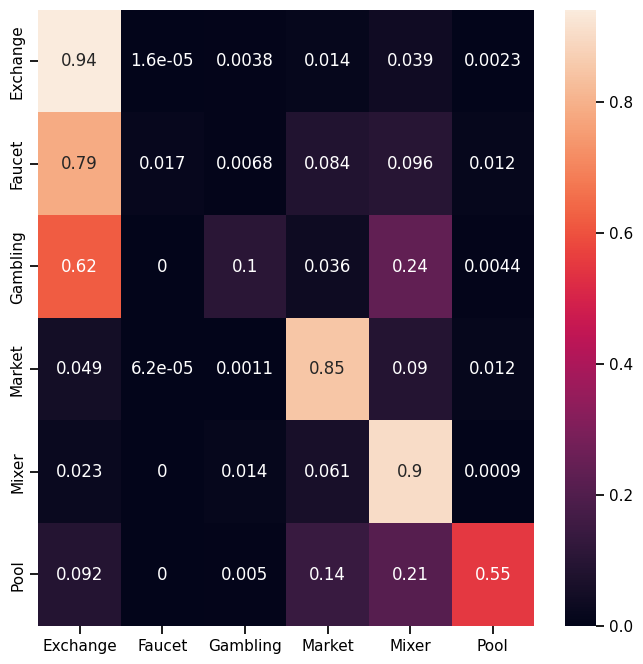

In [11]:
# Average confusion matrix of training set in K-fold

print('Average confusion matrix of training set in {:d}-fold'.format(n_folds))
show_cm_list(train_cm_list, class_names)

In [12]:
def show_rp_list_and_accuracies(rp_list, cm_list, class_names):
    if not rp_list or not cm_list:
        print("The report list or confusion matrix list is empty.")
        return

    summed_metrics = {}
    summed_accuracy = 0
    summed_category_accuracies = {category: 0 for category in class_names}
    category_supports = {category: 0 for category in class_names}

    for report_index, report in enumerate(rp_list):
        for category, metrics in report.items():
            if category == 'accuracy':
                summed_accuracy += metrics
                continue

            if isinstance(metrics, dict) and category in class_names:
                if category not in summed_metrics:
                    summed_metrics[category] = {key: 0 for key in metrics if key != 'support'}
                for metric, value in metrics.items():
                    if metric != 'support':
                        if value > 1:
                            print(f"Debug (initial accumulation): {category} - {metric} has value greater than 1: {value}")
                            value = 1  # 修正异常值
                        summed_metrics[category][metric] += value
                category_supports[category] += metrics.get('support', 0)

        cm = cm_list[report_index]
        for i, category in enumerate(class_names):
            TP = cm[i, i]
            TN = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - TP)
            FP = cm[:, i].sum() - TP
            FN = cm[i, :].sum() - TP
            accuracy = (TP + TN) / float(TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
            summed_category_accuracies[category] += accuracy

    avg_metrics = {}
    total_support = sum(category_supports.values())
    macro_avg = {'precision': 0, 'recall': 0, 'f1-score': 0}
    weighted_avg = {'precision': 0, 'recall': 0, 'f1-score': 0}

    for category, metrics in summed_metrics.items():
        avg_metrics[category] = {metric: value / len(rp_list) for metric, value in metrics.items()}
        for metric in macro_avg:
            macro_avg[metric] += avg_metrics[category][metric] / len(class_names)
            weighted_avg[metric] += (avg_metrics[category][metric] * category_supports[category]) / total_support
            if avg_metrics[category][metric] > 1:
                print(f"Debug (average calculation): {category} - {metric} has value greater than 1: {avg_metrics[category][metric]}")

    avg_accuracy = summed_accuracy / len(rp_list)
    avg_category_accuracies = {category: acc / len(cm_list) for category, acc in summed_category_accuracies.items()}

    print(f"Overall Accuracy: {avg_accuracy:.4f}\n")
    for category, metrics in avg_metrics.items():
        print(f"Category: {category}")
        for metric, value in metrics.items():
            if value > 1:
                print(f"Debug (final report): {category} - {metric} has value greater than 1: {value}")
            print(f"  {metric}: {value:.4f}")
        print(f"  Accuracy: {avg_category_accuracies[category]:.4f}\n")

    print("Category: macro avg")
    for metric, value in macro_avg.items():
        print(f"  {metric}: {value:.4f}")
    print("\nCategory: weighted avg")
    for metric, value in weighted_avg.items():
        print(f"  {metric}: {value:.4f}")

# Assuming n_folds, train_rp_list, train_cm_list, valid_rp_list, valid_cm_list, and class_names are defined elsewhere
print('Average classification report and accuracies of training set in {:d}-fold'.format(n_folds))
show_rp_list_and_accuracies(train_rp_list, train_cm_list, class_names)

print('Average classification report and accuracies of validation set in {:d}-fold'.format(n_folds))
show_rp_list_and_accuracies(valid_rp_list, valid_cm_list, class_names)


Average classification report and accuracies of training set in 5-fold
The report list or confusion matrix list is empty.
Average classification report and accuracies of validation set in 5-fold
Overall Accuracy: 0.8148

Category: Exchange
  precision: 0.8741
  recall: 0.9390
  f1-score: 0.9054
  Accuracy: 0.7212

Category: Faucet
  precision: 0.1467
  recall: 0.0026
  f1-score: 0.0051
  Accuracy: 0.8337

Category: Gambling
  precision: 0.6652
  recall: 0.1030
  f1-score: 0.1778
  Accuracy: 0.8447

Category: Market
  precision: 0.6178
  recall: 0.8361
  f1-score: 0.7104
  Accuracy: 0.9146

Category: Mixer
  precision: 0.7021
  recall: 0.9006
  f1-score: 0.7890
  Accuracy: 0.8715

Category: Pool
  precision: 0.7891
  recall: 0.5155
  f1-score: 0.6233
  Accuracy: 0.9131

Category: macro avg
  precision: 0.6325
  recall: 0.5495
  f1-score: 0.5352

Category: weighted avg
  precision: 0.7974
  recall: 0.8148
  f1-score: 0.7792


Average confusion matrix of validataion set in 5-fold


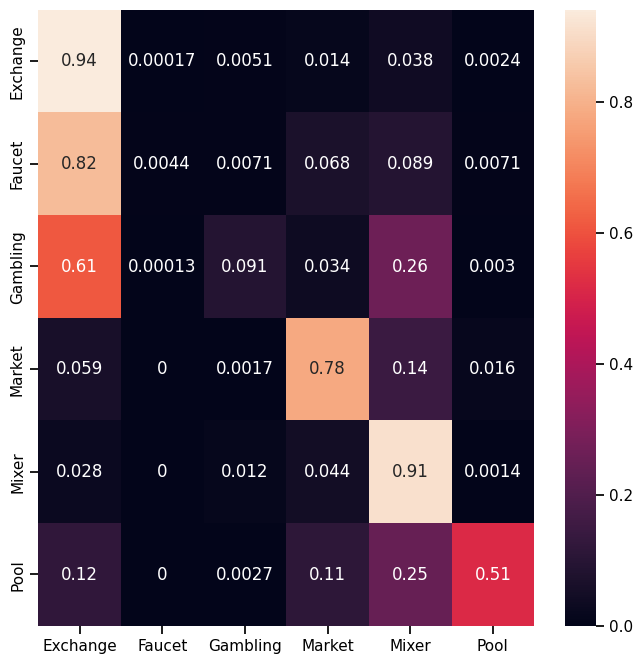

In [86]:
# Average confusion matrix of validataion set in K-fold

print('Average confusion matrix of validataion set in {:d}-fold'.format(n_folds))
show_cm_list(valid_cm_list, class_names)

Average classification report and accuracies of training set in 5-fold
The report list or confusion matrix list is empty.
Average classification report and accuracies of validation set in 5-fold
Overall Accuracy: 0.8148

Category: Exchange
  precision: 0.8741
  recall: 0.9390
  f1-score: 0.9054
  Accuracy: 0.7212

Category: Faucet
  precision: 0.1467
  recall: 0.0026
  f1-score: 0.0051
  Accuracy: 0.8337

Category: Gambling
  precision: 0.6652
  recall: 0.1030
  f1-score: 0.1778
  Accuracy: 0.8447

Category: Market
  precision: 0.6178
  recall: 0.8361
  f1-score: 0.7104
  Accuracy: 0.9146

Category: Mixer
  precision: 0.7021
  recall: 0.9006
  f1-score: 0.7890
  Accuracy: 0.8715

Category: Pool
  precision: 0.7891
  recall: 0.5155
  f1-score: 0.6233
  Accuracy: 0.9131

Category: macro avg
  precision: 0.6325
  recall: 0.5495
  f1-score: 0.5352

Category: weighted avg
  precision: 0.7974
  recall: 0.8148
  f1-score: 0.7792


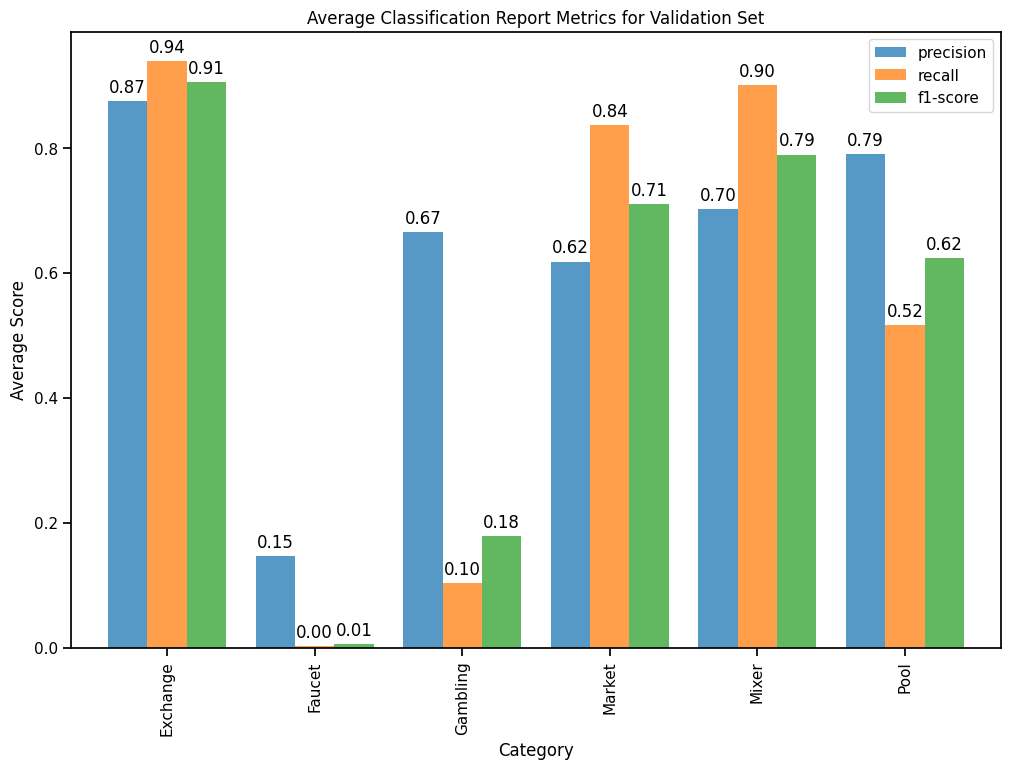

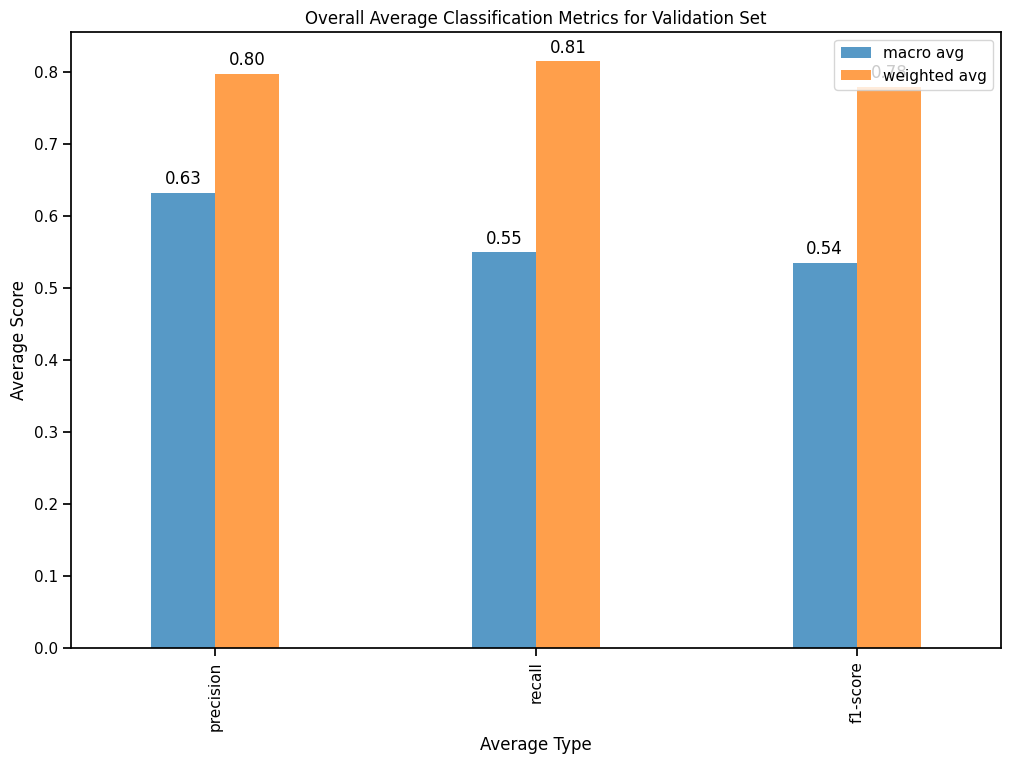

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

def show_rp_list_and_accuracies(rp_list, cm_list, class_names):
    if not rp_list or not cm_list:
        print("The report list or confusion matrix list is empty.")
        return {}, {}, {}

    summed_metrics = {}
    summed_accuracy = 0
    summed_category_accuracies = {category: 0 for category in class_names}
    category_supports = {category: 0 for category in class_names}

    for report_index, report in enumerate(rp_list):
        for category, metrics in report.items():
            if category == 'accuracy':
                summed_accuracy += metrics
                continue

            if isinstance(metrics, dict) and category in class_names:
                if category not in summed_metrics:
                    summed_metrics[category] = {key: 0 for key in metrics if key != 'support'}
                for metric, value in metrics.items():
                    if metric != 'support':
                        if value > 1:
                            print(f"Debug (initial accumulation): {category} - {metric} has value greater than 1: {value}")
                            value = 1  # 修正异常值
                        summed_metrics[category][metric] += value
                category_supports[category] += metrics.get('support', 0)

        cm = cm_list[report_index]
        for i, category in enumerate(class_names):
            TP = cm[i, i]
            TN = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - TP)
            FP = cm[:, i].sum() - TP
            FN = cm[i, :].sum() - TP
            accuracy = (TP + TN) / float(TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
            summed_category_accuracies[category] += accuracy

    avg_metrics = {}
    total_support = sum(category_supports.values())
    macro_avg = {'precision': 0, 'recall': 0, 'f1-score': 0}
    weighted_avg = {'precision': 0, 'recall': 0, 'f1-score': 0}

    for category, metrics in summed_metrics.items():
        avg_metrics[category] = {metric: value / len(rp_list) for metric, value in metrics.items()}
        for metric in macro_avg:
            macro_avg[metric] += avg_metrics[category][metric] / len(class_names)
            weighted_avg[metric] += (avg_metrics[category][metric] * category_supports[category]) / total_support
            if avg_metrics[category][metric] > 1:
                print(f"Debug (average calculation): {category} - {metric} has value greater than 1: {avg_metrics[category][metric]}")

    avg_accuracy = summed_accuracy / len(rp_list)
    avg_category_accuracies = {category: acc / len(cm_list) for category, acc in summed_category_accuracies.items()}

    print(f"Overall Accuracy: {avg_accuracy:.4f}\n")
    for category, metrics in avg_metrics.items():
        print(f"Category: {category}")
        for metric, value in metrics.items():
            if value > 1:
                print(f"Debug (final report): {category} - {metric} has value greater than 1: {value}")
            print(f"  {metric}: {value:.4f}")
        print(f"  Accuracy: {avg_category_accuracies[category]:.4f}\n")

    print("Category: macro avg")
    for metric, value in macro_avg.items():
        print(f"  {metric}: {value:.4f}")
    print("\nCategory: weighted avg")
    for metric, value in weighted_avg.items():
        print(f"  {metric}: {value:.4f}")

    return avg_metrics, macro_avg, weighted_avg

# 假设 n_folds, train_rp_list, train_cm_list, valid_rp_list, valid_cm_list, and class_names are defined elsewhere
print('Average classification report and accuracies of training set in {:d}-fold'.format(n_folds))
train_rp_avg_metrics, train_macro_avg, train_weighted_avg = show_rp_list_and_accuracies(train_rp_list, train_cm_list, class_names)

print('Average classification report and accuracies of validation set in {:d}-fold'.format(n_folds))
valid_rp_avg_metrics, valid_macro_avg, valid_weighted_avg = show_rp_list_and_accuracies(valid_rp_list, valid_cm_list, class_names)

# 繪製平均分類報告指標的柱狀圖
def plot_avg_classification_report(avg_metrics, title):
    df_avg_metrics = pd.DataFrame(avg_metrics).T

    ax = df_avg_metrics.plot(kind='bar', figsize=(12, 8), width=0.8, alpha=0.75)
    ax.set_title(title)
    ax.set_ylabel('Average Score')
    ax.set_xlabel('Category')
    ax.legend(loc='upper right')

    # 在每個柱狀圖上添加數值標籤
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    # 顯示圖表
    plt.show()

# 繪製圖表
plot_avg_classification_report(valid_rp_avg_metrics, 'Average Classification Report Metrics for Validation Set')

# 獨立的程式段，用於繪製包含全部平均分數的表格
def plot_overall_avg_metrics(macro_avg, weighted_avg, title):
    overall_avg_metrics = {
        'macro avg': macro_avg,
        'weighted avg': weighted_avg
    }
    df_overall_avg_metrics = pd.DataFrame(overall_avg_metrics)

    ax = df_overall_avg_metrics.plot(kind='bar', figsize=(12, 8), width=0.4, alpha=0.75)
    ax.set_title(title)
    ax.set_ylabel('Average Score')
    ax.set_xlabel('Average Type')
    ax.legend(loc='upper right')

    # 在每個柱狀圖上添加數值標籤
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    # 顯示圖表
    plt.show()

# 繪製圖表
plot_overall_avg_metrics(valid_macro_avg, valid_weighted_avg, 'Overall Average Classification Metrics for Validation Set')


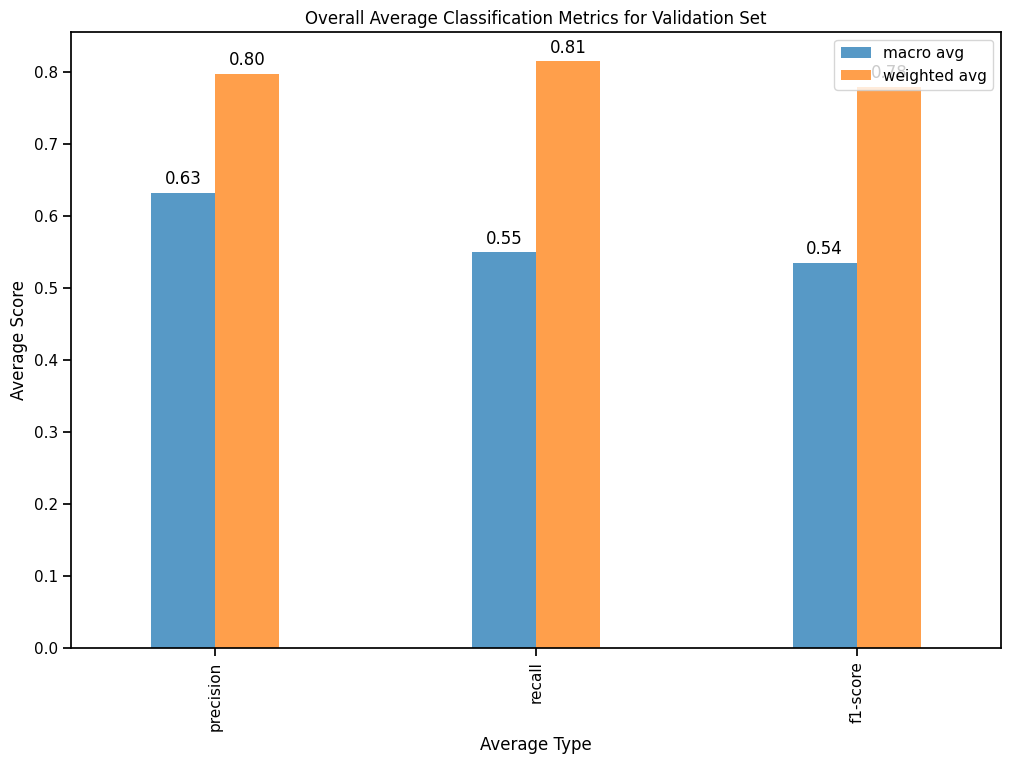

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# 假设 valid_macro_avg 和 valid_weighted_avg 已经定义并包含有效数据
def plot_overall_avg_metrics(macro_avg, weighted_avg, title):
    overall_avg_metrics = {
        'macro avg': macro_avg,
        'weighted avg': weighted_avg
    }
    df_overall_avg_metrics = pd.DataFrame(overall_avg_metrics)

    ax = df_overall_avg_metrics.plot(kind='bar', figsize=(12, 8), width=0.4, alpha=0.75)
    ax.set_title(title)
    ax.set_ylabel('Average Score')
    ax.set_xlabel('Average Type')
    ax.legend(loc='upper right')

    # 在每個柱狀圖上添加數值標籤
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    # 顯示圖表
    plt.show()

# 繪製圖表
plot_overall_avg_metrics(valid_macro_avg, valid_weighted_avg, 'Overall Average Classification Metrics for Validation Set')


Average classification report and accuracies of training set in 5-fold
The report list or confusion matrix list is empty.
Average classification report and accuracies of validation set in 5-fold
Overall Accuracy: 0.8148

Category: Exchange
  precision: 0.8741
  recall: 0.9390
  f1-score: 0.9054
  Accuracy: 0.7212

Category: Faucet
  precision: 0.1467
  recall: 0.0026
  f1-score: 0.0051
  Accuracy: 0.8337

Category: Gambling
  precision: 0.6652
  recall: 0.1030
  f1-score: 0.1778
  Accuracy: 0.8447

Category: Market
  precision: 0.6178
  recall: 0.8361
  f1-score: 0.7104
  Accuracy: 0.9146

Category: Mixer
  precision: 0.7021
  recall: 0.9006
  f1-score: 0.7890
  Accuracy: 0.8715

Category: Pool
  precision: 0.7891
  recall: 0.5155
  f1-score: 0.6233
  Accuracy: 0.9131

Category: macro avg
  precision: 0.6325
  recall: 0.5495
  f1-score: 0.5352

Category: weighted avg
  precision: 0.7974
  recall: 0.8148
  f1-score: 0.7792


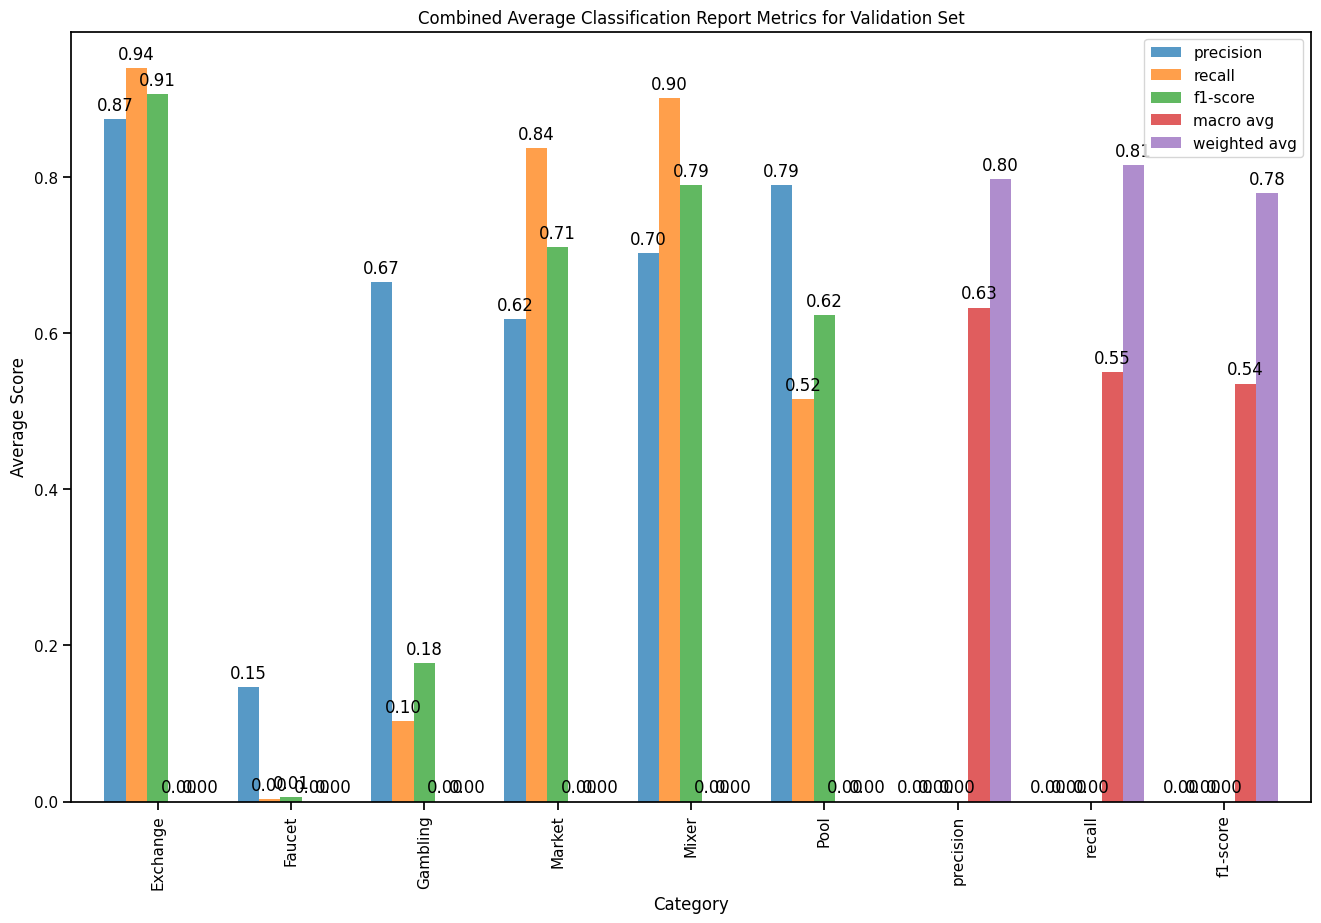

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

def show_rp_list_and_accuracies(rp_list, cm_list, class_names):
    if not rp_list or not cm_list:
        print("The report list or confusion matrix list is empty.")
        return {}, {}, {}

    summed_metrics = {}
    summed_accuracy = 0
    summed_category_accuracies = {category: 0 for category in class_names}
    category_supports = {category: 0 for category in class_names}

    for report_index, report in enumerate(rp_list):
        for category, metrics in report.items():
            if category == 'accuracy':
                summed_accuracy += metrics
                continue

            if isinstance(metrics, dict) and category in class_names:
                if category not in summed_metrics:
                    summed_metrics[category] = {key: 0 for key in metrics if key != 'support'}
                for metric, value in metrics.items():
                    if metric != 'support':
                        if value > 1:
                            print(f"Debug (initial accumulation): {category} - {metric} has value greater than 1: {value}")
                            value = 1  # 修正异常值
                        summed_metrics[category][metric] += value
                category_supports[category] += metrics.get('support', 0)

        cm = cm_list[report_index]
        for i, category in enumerate(class_names):
            TP = cm[i, i]
            TN = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - TP)
            FP = cm[:, i].sum() - TP
            FN = cm[i, :].sum() - TP
            accuracy = (TP + TN) / float(TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
            summed_category_accuracies[category] += accuracy

    avg_metrics = {}
    total_support = sum(category_supports.values())
    macro_avg = {'precision': 0, 'recall': 0, 'f1-score': 0}
    weighted_avg = {'precision': 0, 'recall': 0, 'f1-score': 0}

    for category, metrics in summed_metrics.items():
        avg_metrics[category] = {metric: value / len(rp_list) for metric, value in metrics.items()}
        for metric in macro_avg:
            macro_avg[metric] += avg_metrics[category][metric] / len(class_names)
            weighted_avg[metric] += (avg_metrics[category][metric] * category_supports[category]) / total_support
            if avg_metrics[category][metric] > 1:
                print(f"Debug (average calculation): {category} - {metric} has value greater than 1: {avg_metrics[category][metric]}")

    avg_accuracy = summed_accuracy / len(rp_list)
    avg_category_accuracies = {category: acc / len(cm_list) for category, acc in summed_category_accuracies.items()}

    print(f"Overall Accuracy: {avg_accuracy:.4f}\n")
    for category, metrics in avg_metrics.items():
        print(f"Category: {category}")
        for metric, value in metrics.items():
            if value > 1:
                print(f"Debug (final report): {category} - {metric} has value greater than 1: {value}")
            print(f"  {metric}: {value:.4f}")
        print(f"  Accuracy: {avg_category_accuracies[category]:.4f}\n")

    print("Category: macro avg")
    for metric, value in macro_avg.items():
        print(f"  {metric}: {value:.4f}")
    print("\nCategory: weighted avg")
    for metric, value in weighted_avg.items():
        print(f"  {metric}: {value:.4f}")

    return avg_metrics, macro_avg, weighted_avg

# 假设 n_folds, train_rp_list, train_cm_list, valid_rp_list, valid_cm_list, and class_names are defined elsewhere
print('Average classification report and accuracies of training set in {:d}-fold'.format(n_folds))
train_rp_avg_metrics, train_macro_avg, train_weighted_avg = show_rp_list_and_accuracies(train_rp_list, train_cm_list, class_names)

print('Average classification report and accuracies of validation set in {:d}-fold'.format(n_folds))
valid_rp_avg_metrics, valid_macro_avg, valid_weighted_avg = show_rp_list_and_accuracies(valid_rp_list, valid_cm_list, class_names)

# 繪製包含所有分類報告指標及其宏平均和加權平均值的合併柱狀圖
def plot_combined_avg_classification_report(avg_metrics, macro_avg, weighted_avg, title):
    df_avg_metrics = pd.DataFrame(avg_metrics).T

    # 添加宏平均和加權平均到數據框
    macro_df = pd.DataFrame(macro_avg, index=['macro avg']).T
    weighted_df = pd.DataFrame(weighted_avg, index=['weighted avg']).T
    df_avg_metrics = pd.concat([df_avg_metrics, macro_df, weighted_df], axis=1)

    ax = df_avg_metrics.plot(kind='bar', figsize=(16, 10), width=0.8, alpha=0.75)
    ax.set_title(title)
    ax.set_ylabel('Average Score')
    ax.set_xlabel('Category')
    ax.legend(loc='upper right')

    # 在每個柱狀圖上添加數值標籤
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    # 顯示圖表
    plt.show()

# 繪製合併圖表
plot_combined_avg_classification_report(valid_rp_avg_metrics, valid_macro_avg, valid_weighted_avg, 'Combined Average Classification Report Metrics for Validation Set')


In [ ]:
# Feature Importance

if len(fi_list) == 0:
    exit()
    sys.exit()

try:
    print(clf.importance_type)
except Exception as e:
    print(e)

fi_avg = np.mean(fi_list, axis=0)
# print(fi_avg)
print(fi_avg.argsort()[::-1])
if run_from_ipython():
    df_feature_importances = pd.DataFrame({'name': features, 'importance': fi_avg})
    df_top_10 = df_feature_importances.nlargest(10, columns='importance')
    plt.figure()
    sns.barplot(x='importance', y='name', data=df_top_10)  # Modified this line


In [ ]:
if run_from_ipython():
    plt.figure(figsize=(16, 32))
    for i in range(10):
        feature_index = df_top_10.index[i]
        feature_name = list(df_top_10['name'])[i]
        feature_data = X[:, feature_index]

        # Check if the lengths match
        if len(y_names) != len(feature_data):
            print(f"Length mismatch for feature '{feature_name}': Length of y_names is {len(y_names)}, length of feature data is {len(feature_data)}")
            continue  # Skip this iteration

        plt.subplot(5, 2, i+1)
        plt.title(feature_name)
        ax = sns.boxplot(x=y_names, y=feature_data)


In [18]:
# 平均分類報告
print('Average classification report of validation set in {:d}-fold'.format(n_folds))
valid_rp_avg = compute_avg_classification_report(valid_rp_list)
show_avg_classification_report(valid_rp_avg)

Average classification report of validation set in 5-fold


NameError: name 'compute_avg_classification_report' is not defined

In [17]:
# Average classification report of validataion set in K-fold

print('Average classification report of validataion set in {:d}-fold'.format(n_folds))
show_rp_list(valid_rp_list)

# 初始化用於存儲每個類別平均精確度、召回率和F1分數的字典
averages = {}

# 遍歷每個報告
for report in valid_rp_list:
    # 遍歷報告中的每個類別
    for category, metrics in report.items():
        # 確保 metrics 是字典類型
        if isinstance(metrics, dict):
            # 如果類別第一次出現，則初始化
            if category not in averages:
                averages[category] = {'precision': 0, 'recall': 0, 'f1-score': 0, 'count': 0}
            
            # 累加該類別的指標值
            for metric in ['precision', 'recall', 'f1-score']:
                averages[category][metric] += metrics.get(metric, 0)
            averages[category]['count'] += 1

# 計算平均值
for category, metrics in averages.items():
    for metric in ['precision', 'recall', 'f1-score']:
        metrics[metric] /= metrics['count']

# 刪除計數鍵
for category in averages:
    del averages[category]['count']

# 轉換成DataFrame
df_averages = pd.DataFrame(averages).T

# 繪製柱狀圖並添加數值標籤
ax = df_averages.plot(kind='bar', figsize=(12, 8), width=0.8, alpha=0.75)
ax.set_title('Average Classification Report Metrics')
ax.set_ylabel('Average Score')
ax.set_xlabel('Category')
ax.legend(loc='upper right')

# 在每個柱狀圖上添加數值標籤
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# 顯示圖表
plt.show()

Average classification report of validataion set in 5-fold


TypeError: 'float' object is not iterable

[0]


C:\Users\SIEMINGFONG\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\SIEMINGFONG\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


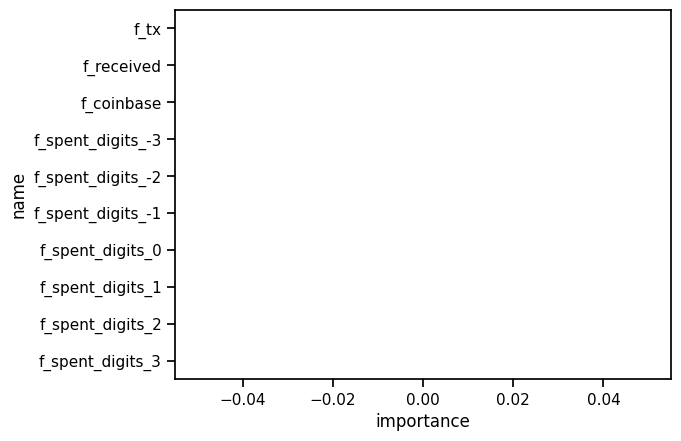

In [19]:
fi_avg = np.mean(fi_list, axis=0)
# print(fi_avg)
print(fi_avg.argsort()[::-1])
if run_from_ipython():
    df_feature_importances = pd.DataFrame({'name': features, 'importance': fi_avg})
    df_least_10 = df_feature_importances.nsmallest(10, columns='importance')
    plt.figure()
    sns.barplot(x='importance', y='name', data=df_least_10)  # Corrected this line


C:\Users\SIEMINGFONG\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\SIEMINGFONG\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[0]


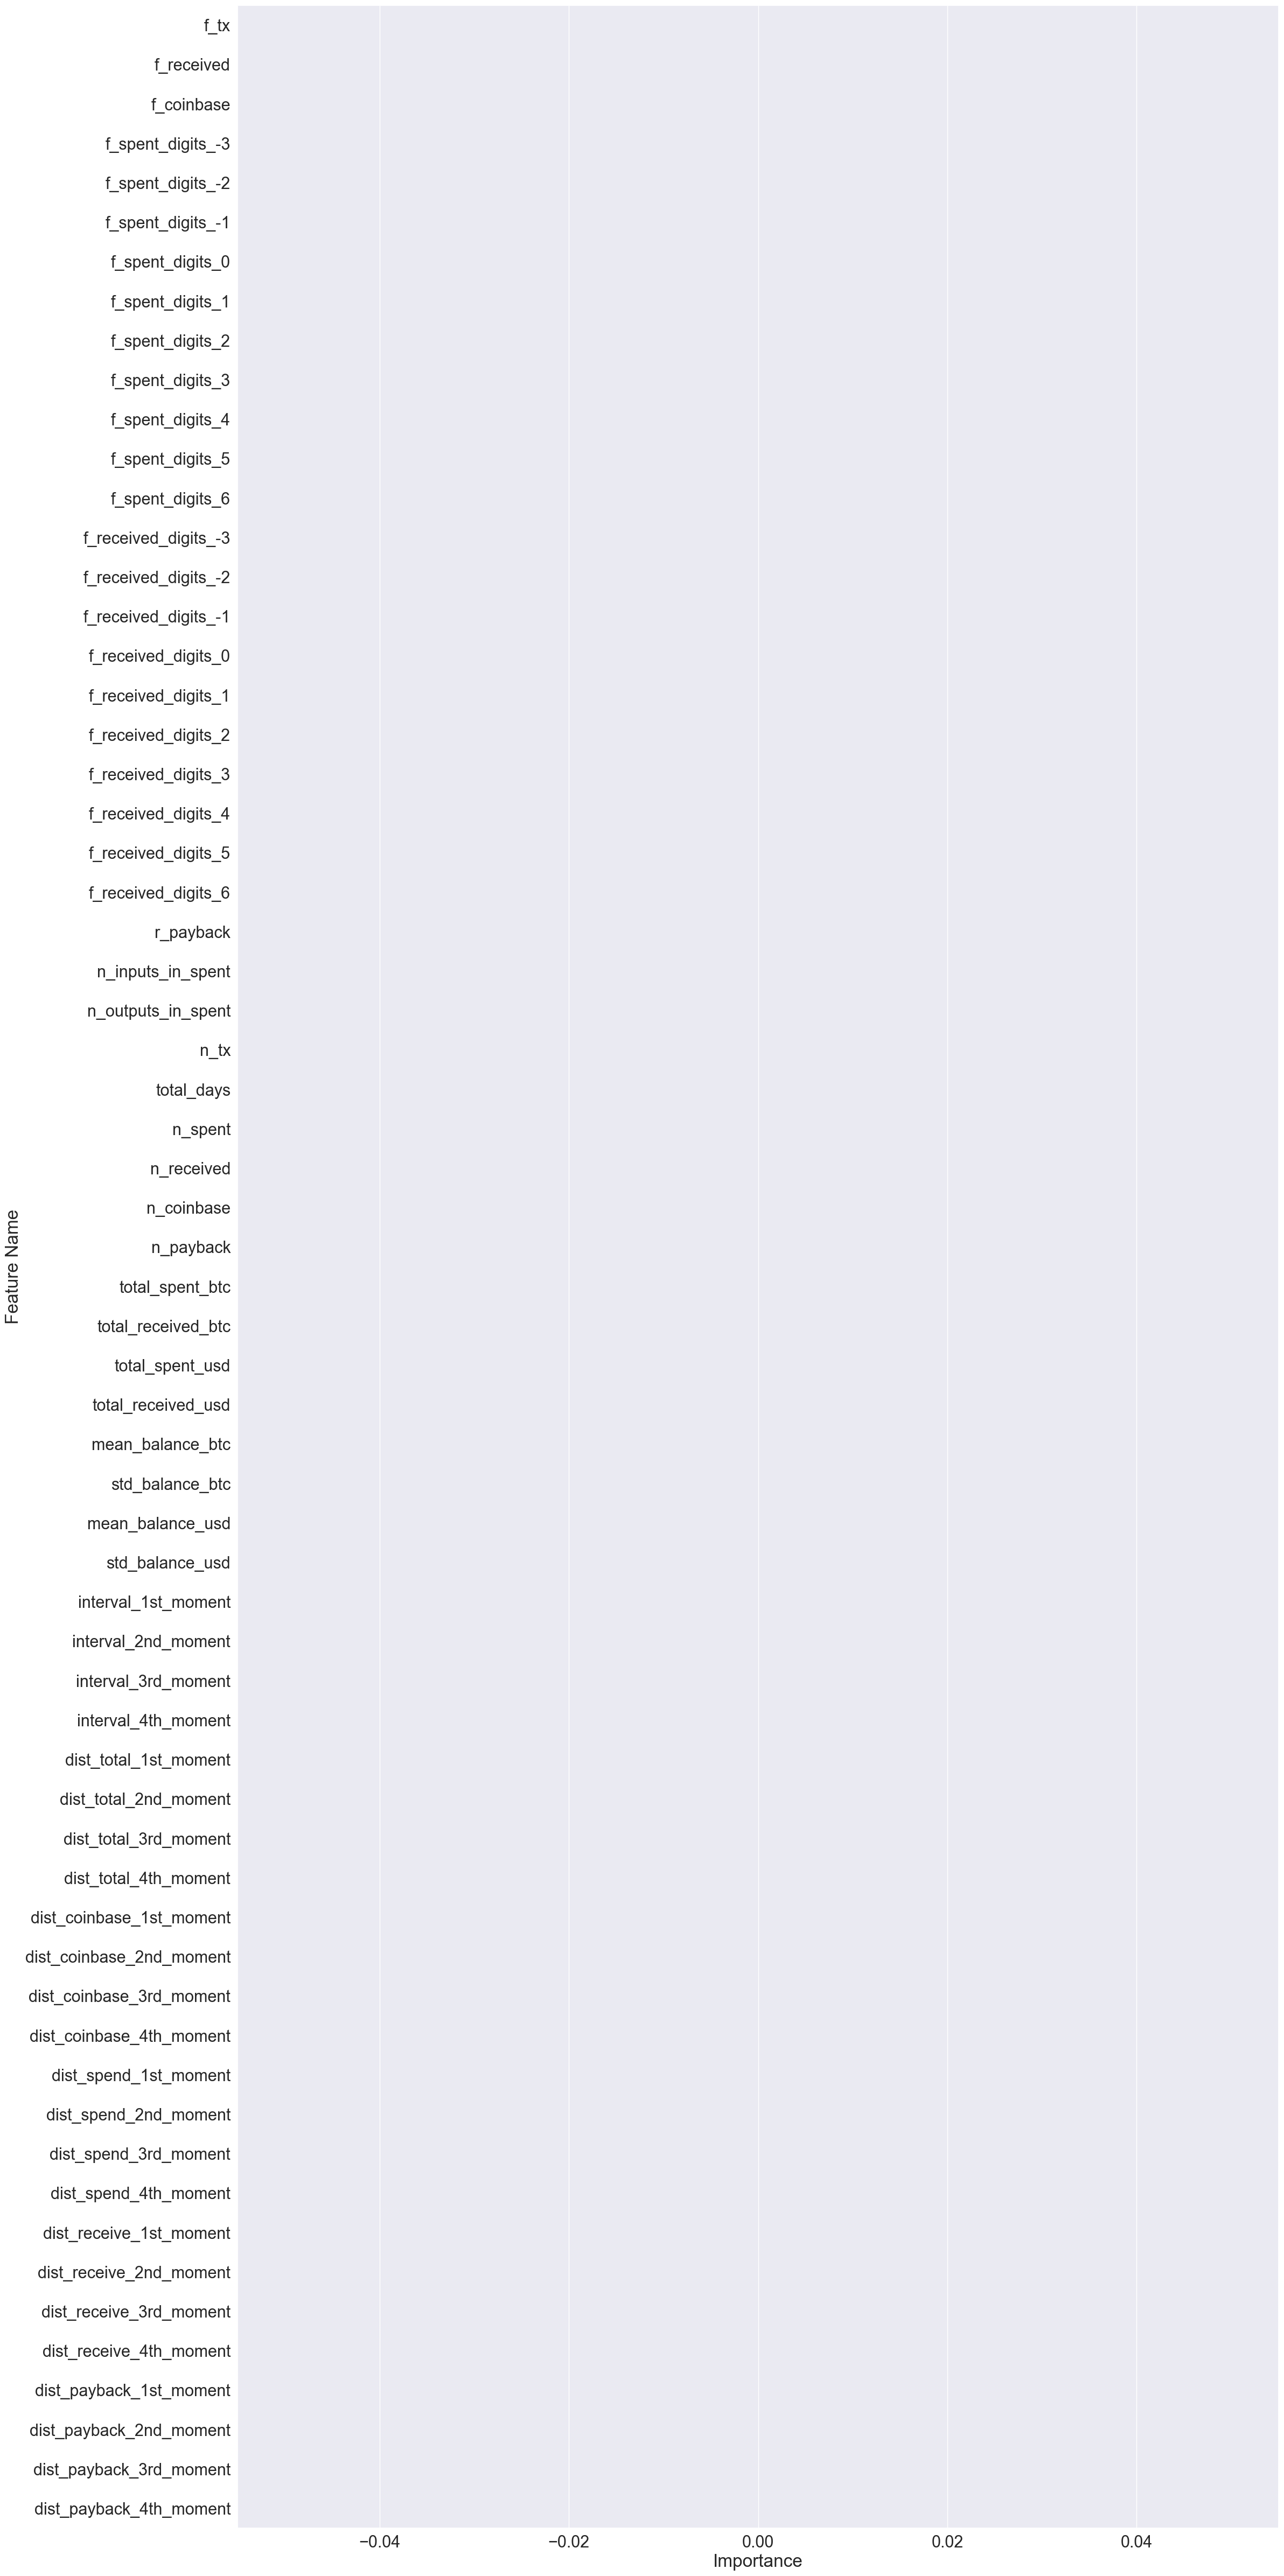

In [20]:
fi_avg = np.mean(fi_list, axis=0)
print(fi_avg.argsort()[::-1])
if run_from_ipython():
    df_feature_importances = pd.DataFrame({'Feature Name': features, 'Importance': fi_avg})
    df_least_10 = df_feature_importances.nlargest(len(features), columns='Importance')
    plt.figure(figsize=(24, 48))
    sns.set(font_scale=2)
    sns.barplot(x='Importance', y='Feature Name', data=df_least_10)  # Corrected this line
    sns.set(font_scale=1)
    plt.tight_layout()
    # plt.savefig('top_10_and_last_10_feature_importance.png')  # Uncomment this line to save the figure


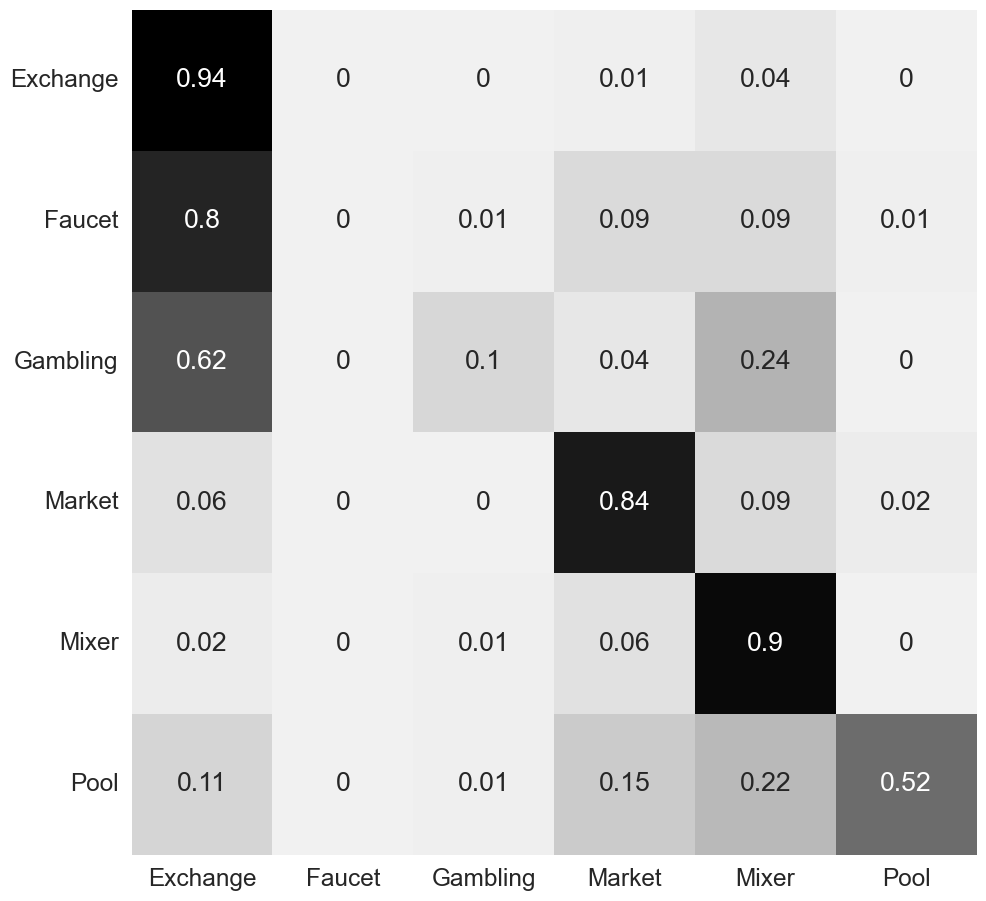

In [21]:
from matplotlib.colors import ListedColormap

cm_avg = np.mean(valid_cm_list, axis=0)
# print(cm_avg)
if run_from_ipython():
    df_cm = pd.DataFrame(cm_avg, index=class_names, columns=class_names)
    plt.figure(figsize=(10, 10))
    # cmap = sns.diverging_palette(220, 10, as_cmap=True)
    cmap = sns.light_palette('black', as_cmap=True)
    # cmap = ListedColormap(['white'])
    sns.set(font_scale=1.6)
    sns.heatmap(df_cm.round(2), annot=True, square=True, cbar=False, cmap=cmap)
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    sns.set(font_scale=1)
    plt.tight_layout()
    # plt.savefig('confusion_matrix.png')  # Uncomment this line to save the figure

Average Training Confusion Matrix:
[[9.40856932e-01 1.57911359e-05 3.84777345e-03 1.43330877e-02
  3.86409096e-02 2.30550584e-03]
 [7.85313243e-01 1.65631986e-02 6.75595090e-03 8.39129206e-02
  9.56847540e-02 1.17699327e-02]
 [6.20704265e-01 0.00000000e+00 1.03066355e-01 3.63441302e-02
  2.35475981e-01 4.40926864e-03]
 [4.93079860e-02 6.17856040e-05 1.05043164e-03 8.47503602e-01
  9.03980475e-02 1.16781474e-02]
 [2.26643142e-02 0.00000000e+00 1.39553716e-02 6.09631023e-02
  9.01514840e-01 9.02371595e-04]
 [9.17974378e-02 0.00000000e+00 4.95165579e-03 1.41823060e-01
  2.11782370e-01 5.49645476e-01]]

Average Validation Confusion Matrix:
[[9.38983051e-01 2.73713022e-04 4.10569534e-03 1.48226129e-02
  3.88040846e-02 3.01084325e-03]
 [7.99479780e-01 2.61629011e-03 7.84127587e-03 8.71691665e-02
  9.06891969e-02 1.22042909e-02]
 [6.20931734e-01 0.00000000e+00 1.02971539e-01 3.64414665e-02
  2.35116290e-01 4.53897061e-03]
 [5.56086618e-02 0.00000000e+00 1.23578873e-03 8.36131789e-01
  9.14532

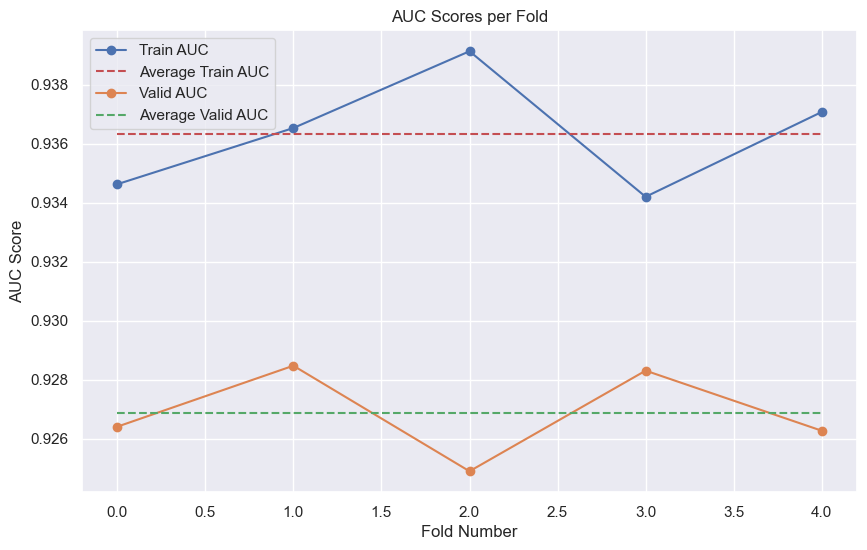

In [22]:
import matplotlib.pyplot as plt

# 计算平均混淆矩阵
avg_train_cm = np.mean(train_cm_list, axis=0)
avg_valid_cm = np.mean(valid_cm_list, axis=0)

# 计算平均AUC分数
avg_train_auc = np.mean(train_auc_list)
avg_valid_auc = np.mean(valid_auc_list)

# 展示平均混淆矩阵
print("Average Training Confusion Matrix:")
print(avg_train_cm)
print("\nAverage Validation Confusion Matrix:")
print(avg_valid_cm)

# 展示平均AUC分数
print(f"\nAverage Train AUC: {avg_train_auc}")
print(f"Average Valid AUC: {avg_valid_auc}")

# 绘制AUC分数图表
plt.figure(figsize=(10, 6))
plt.plot(train_auc_list, label='Train AUC', marker='o')
plt.plot([avg_train_auc] * len(train_auc_list), 'r--', label='Average Train AUC')
plt.plot(valid_auc_list, label='Valid AUC', marker='o')
plt.plot([avg_valid_auc] * len(valid_auc_list), 'g--', label='Average Valid AUC')
plt.title('AUC Scores per Fold')
plt.xlabel('Fold Number')
plt.ylabel('AUC Score')
plt.legend()
plt.show()

C:\Users\SIEMINGFONG\AppData\Local\Temp\ipykernel_19780\1393660083.py:20: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


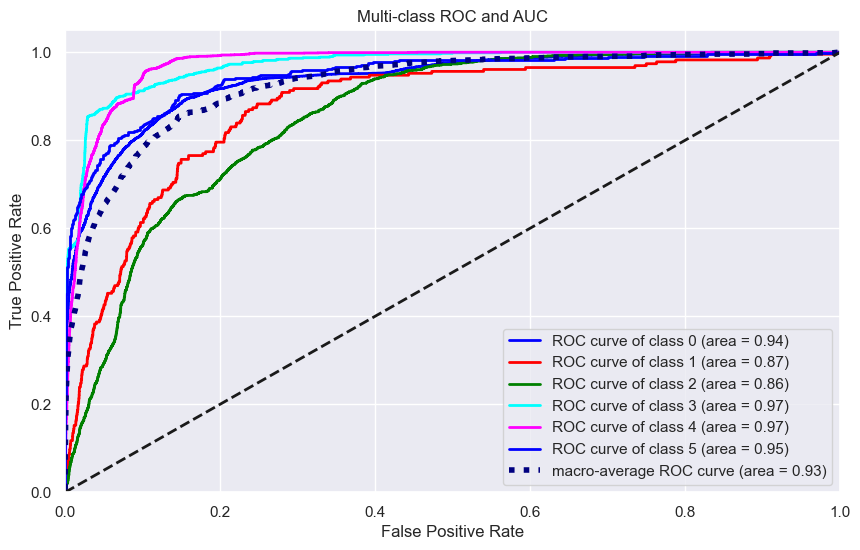

In [23]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

# 计算每个类别的FPR和TPR
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(class_names)  # 类别的数量

# 计算每个类别的ROC曲线和AUC分数
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_valid, y_valid_prob[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# 计算宏观平均ROC曲线和AUC分数
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# 绘制所有类别的ROC曲线
plt.figure(figsize=(10, 6))
colors = cycle(['blue', 'red', 'green', 'cyan', 'magenta'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

# 绘制宏观平均ROC曲线
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

# 绘制对角线
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC and AUC')
plt.legend(loc="lower right")
plt.show()
